In [1]:
import os, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import PIL.Image as Image
import re
import numpy as np
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torchvision.models import resnet50
from torch.optim.lr_scheduler import OneCycleLR

train_folder = 'images/images/'

In [2]:
filenames=[]
for filename in os.listdir(train_folder):
    filenames.append(filename)

# remove all files that are not images
for filename in filenames:
    if not filename.endswith('.jpg'):
        filenames.remove(filename)

In [3]:


labels=[]
for filename in filenames:
    label = re.split('_', filename)
    if len(label) == 2:
        label = label[0]
    else:
        label = label[0]+"_"+label[1]
    labels.append(label)

# print unique labels
print(set(labels))

# count classes in labels
from collections import Counter
Counter(labels)


{'great_pyrenees', 'wheaten_terrier', 'Birman', 'Sphynx', 'english_cocker', 'german_shorthaired', 'Russian_Blue', 'chihuahua', 'yorkshire_terrier', 'Siamese', 'boxer', 'havanese', 'Abyssinian', 'basset_hound', 'american_pit', 'japanese_chin', 'samoyed', 'pug', 'British_Shorthair', 'Bombay', 'leonberger', 'saint_bernard', 'Bengal', 'pomeranian', 'american_bulldog', 'english_setter', 'newfoundland', 'keeshond', 'miniature_pinscher', 'Egyptian_Mau', 'beagle', 'Persian', 'shiba_inu', 'Maine_Coon', 'scottish_terrier', 'Ragdoll', 'staffordshire_bull'}


Counter({'Egyptian_Mau': 200,
         'pug': 200,
         'basset_hound': 200,
         'Siamese': 200,
         'shiba_inu': 200,
         'Birman': 200,
         'leonberger': 200,
         'saint_bernard': 200,
         'Abyssinian': 200,
         'miniature_pinscher': 200,
         'wheaten_terrier': 200,
         'scottish_terrier': 199,
         'pomeranian': 200,
         'german_shorthaired': 200,
         'english_setter': 200,
         'newfoundland': 200,
         'Sphynx': 200,
         'British_Shorthair': 200,
         'Bombay': 200,
         'boxer': 200,
         'great_pyrenees': 200,
         'samoyed': 200,
         'Russian_Blue': 200,
         'Persian': 200,
         'japanese_chin': 200,
         'Ragdoll': 200,
         'english_cocker': 200,
         'Maine_Coon': 200,
         'havanese': 200,
         'Bengal': 200,
         'american_pit': 200,
         'keeshond': 200,
         'american_bulldog': 200,
         'chihuahua': 200,
         'beagle': 200,
  

In [4]:
classes = list(set(labels))
classes_idx= {classes[i]: i for i in range(len(classes))}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

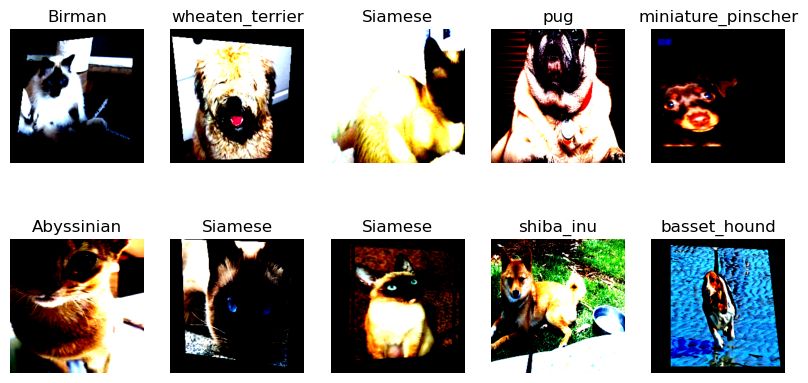

In [5]:
class PetDataset(Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        try:
            image = Image.open(train_folder+self.filenames[idx])
            image = image.convert('RGB')
            label = classes_idx[self.labels[idx]]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(e)
            print("Error loading image: ", self.filenames[idx], "idx", idx)
transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300), antialias=True),
    # horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),
    # jitter brightness, contrast and saturation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # randomly crop image
    transforms.RandomCrop(224, pad_if_needed=True, padding_mode='reflect'),
    # warp
    transforms.RandomPerspective(distortion_scale=0.3, p=0.6),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


sample_dataset=PetDataset(filenames[:20], labels[:20], transform=transform)
sample_dataloader=DataLoader(sample_dataset, batch_size=10, shuffle=True)

# visualize a batch of images using the dataloader
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
index=0
for xb, yb in sample_dataloader:
    for row in range(2):
        for col in range(5):
            ax[row, col].imshow(xb[row*5+col].permute(1, 2, 0))
            ax[row, col].set_title(classes[yb[row*5+col].item()])
            ax[row, col].axis('off')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42, shuffle=True)

In [7]:


# use a pretrained resnte50

class OxfordPetsModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.resnet50=resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet50.fc=nn.Sequential(
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 37)
        )
        for param in self.resnet50.parameters():
            param.requires_grad = False

        for param in self.resnet50.fc.parameters():
            param.requires_grad = True

    def forward(self, xb):
        return self.resnet50(xb)

model=OxfordPetsModel()
model(xb).shape

torch.Size([10, 37])

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [9]:
batch_size=128

train_dataset=PetDataset(X_train, y_train, transform=transform)
test_dataset=PetDataset(X_test, y_test, transform=transform)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [10]:
lr=0.01

class Learner():

    def __init__(self, model, loss, train_loader, test_loader):
        self.loss_fn = loss
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader


    def train_batch(self,  xb, yb, optimizer):
        xb=xb.to(device)
        yb=yb.to(device)
        y_hat=model(xb)
        loss = self.loss_fn(y_hat, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds=torch.argmax(y_hat, dim=1)
        return loss.item(), (preds==yb).sum().item()/len(yb)

    def fit_one_cycle(self, lr):
        model.train()
        optimizer=torch.optim.Adam(model.parameters(), lr=lr)
        scheduler=OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(self.train_loader), epochs=1)
        losses=[]
        accs=[]
        bar=tqdm(self.train_loader)
        for xb, yb in bar:
            loss, acc=self.train_batch(xb, yb, optimizer)
            losses.append(loss)
            accs.append(acc)
            scheduler.step()
            bar.set_description(f"current lr: {scheduler.get_last_lr()}")
        return losses, np.mean(accs), self.get_accuracy()

    def get_accuracy(self):
        model.eval()
        correct=0
        for xb, yb in self.test_loader:
            xb=xb.to(device)
            yb=yb.to(device)
            y_hat=self.model(xb)
            y_pred=torch.argmax(y_hat, dim=1)
            correct+=(y_pred==yb).sum().item()
        return correct/len(self.test_loader.dataset)


In [11]:
model = OxfordPetsModel().to(device)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
learner = Learner(model, nn.CrossEntropyLoss(), train_loader, test_loader)

  0%|          | 0/47 [00:00<?, ?it/s]

Test accuracy:  0.7483085250338295
Train accuracy:  0.5186724290780143


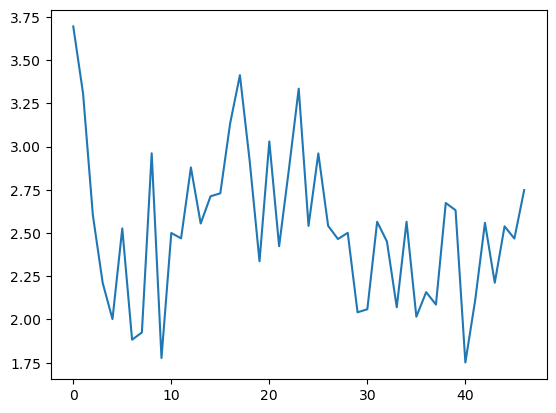

In [12]:
losses, train_acc, test_acc=learner.fit_one_cycle(0.1)
print("Test accuracy: ", test_acc)
print("Train accuracy: ", train_acc)
plt.plot(losses, label='loss')
plt.show()

  0%|          | 0/47 [00:00<?, ?it/s]

Test accuracy:  0.7929634641407307
Train accuracy:  0.5530252659574468


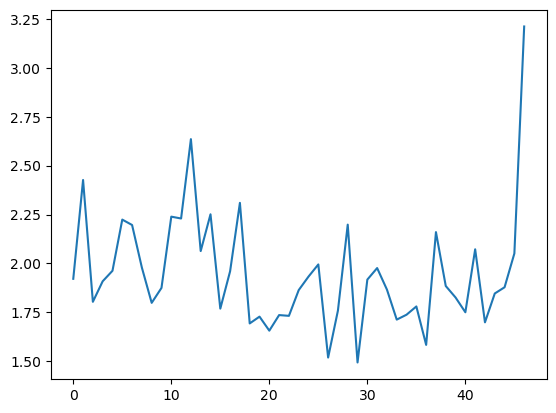

In [13]:
losses, train_acc, test_acc=learner.fit_one_cycle(0.01)
print("Test accuracy: ", test_acc)
print("Train accuracy: ", train_acc)
plt.plot(losses, label='loss')
plt.show()

  0%|          | 0/47 [00:00<?, ?it/s]

Test accuracy:  0.8064952638700947
Train accuracy:  0.5771276595744681


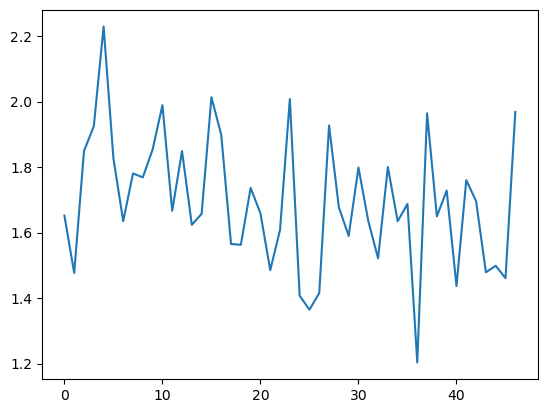

In [14]:
losses, train_acc, test_acc=learner.fit_one_cycle(0.01)
print("Test accuracy: ", test_acc)
print("Train accuracy: ", train_acc)
plt.plot(losses, label='loss')
plt.show()

  0%|          | 0/47 [00:00<?, ?it/s]

Test accuracy:  0.7848443843031123
Train accuracy:  0.5705341312056738


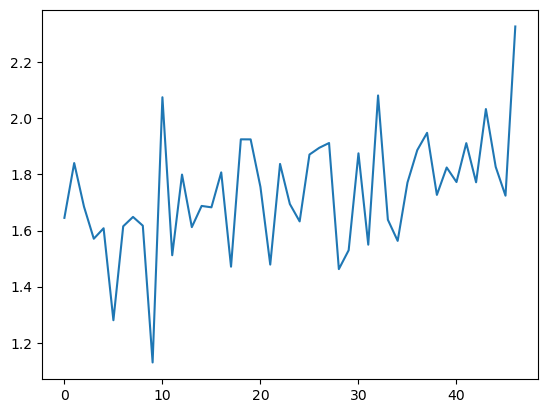

In [15]:
losses, train_acc, test_acc=learner.fit_one_cycle(0.01)
print("Test accuracy: ", test_acc)
print("Train accuracy: ", train_acc)
plt.plot(losses, label='loss')
plt.show()

  0%|          | 0/47 [00:00<?, ?it/s]

Test accuracy:  0.774018944519621
Train accuracy:  0.5443816489361702


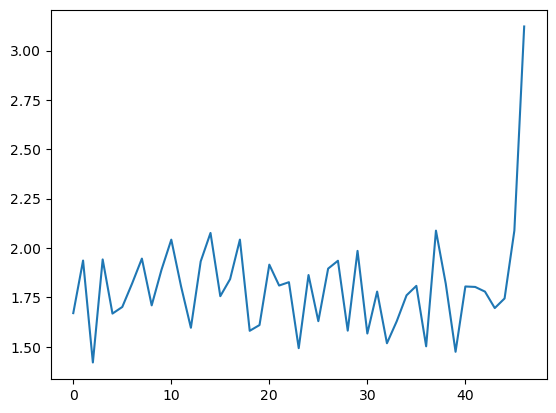

In [16]:
losses, train_acc, test_acc=learner.fit_one_cycle(0.001)
print("Test accuracy: ", test_acc)
print("Train accuracy: ", train_acc)
plt.plot(losses, label='loss')
plt.show()